In [1]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import time
import json
import datetime
import joblib

import boto3
import sagemaker
from sagemaker.model import Model
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter, HyperparameterTuner
from tqdm import tqdm

import numpy as np
import pandas as pd
from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt
from src.train_entry import TSTrainer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='forecast')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

In [3]:
s3 = boto3.client('s3')

raw_data_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/raw-data'

train_val_test_path = {
    'train': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
    'test': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test'
}
train_val_test_path, raw_data_path

({'train': 's3://elo-ml-sagemaker/gas-forecast-price/input-data/train',
  'test': 's3://elo-ml-sagemaker/gas-forecast-price/input-data/test'},
 's3://elo-ml-sagemaker/gas-forecast-price/raw-data')

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sm_boto3 = boto3.client('sagemaker')
ecr_boto3 = boto3.client('ecr')
lambda_boto3 = boto3.client('lambda')
iam_boto3 = boto3.resource('iam')
apigateway_boto3 = boto3.client('apigateway')
role = sagemaker.get_execution_role()

# Preprocess

## build docker image

In [5]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh preprocess-latest preprocess {config['ecr_repository']}

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                                         
[+] Building 0.2s (2/3)                                                         
 => [internal] load build definition from preprocess.Dockerfile            0.0s
 => => transferring dockerfile: 108B                                       0.0s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load metadata for docker.io/library/python:3.10.12-slim-bu  0.1s
[+] Building 0.3s (2/3)                                                         
 => [internal] load build definition from preprocess.Dockerfile            0.0s
 => => transferring dockerfile: 108

In [6]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if 'imageTag' in ecr_meta_data_dict and ecr_meta_data_dict['imageTag'].startswith('preprocess'):
        preprocess_image_tag = ecr_meta_data_dict['imageTag']

preprocess_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{preprocess_image_tag}'

In [7]:
# Clear tmp directory in case we run out of space
!sudo rm -rf /tmp/tmp*

## run locally

In [8]:
test_processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type='local',
    instance_count=config['preprocess_instance_count'],
    base_job_name=config['preprocess_base_job_name'],
    entrypoint=['python3', 'preprocess_entry.py']
)

test_processor.run(
    # The data sets are loaded from the source S3 path to the destination path in the processing container
    inputs=[ProcessingInput(
        source=raw_data_path,
        destination=config['preprocess_input']
    )],
    outputs=[
        ProcessingOutput(
            # The processing script writes train and test splits to these locations in the container
            source=os.path.join(config['preprocess_output'], key),
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_val_test_path[key]
        ) for key in train_val_test_path
    ],
    # Run in test mode to not upload the preprocessed data to S3
    arguments=['--test_mode']
)

INFO:sagemaker:Creating processing-job with name processing-job-2024-06-18-17-16-34-522
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.local_session:Starting processing job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-4b1ut:
    container_name: ump8jqpemk-algo-1-4b1ut
    entrypoint:
    - python3
    - preprocess_entry.py
    - --test_mode
    environment: []
    image: 616052791267.dkr.ecr.us-east-2.amazonaws.com/gas-forecast-price:preprocess-latest
    networks:
      sagemaker-local:
        aliases:
        - algo-1-4b1ut
    stdin_open: 

 Container ump8jqpemk-algo-1-4b1ut  Creating
 Container ump8jqpemk-algo-1-4b1ut  Created
Attaching to ump8jqpemk-algo-1-4b1ut
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,920 INFO __main__: Loading raw data...
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,930 INFO __main__: Splitting data into train and test sets...
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,932 INFO __main__: Train set period: 2013-01-07 to 2023-12-18
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,932 INFO __main__: Test set period: 2023-12-25 to 2024-06-17
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,932 INFO __main__: Forecasting Covid-19 data...
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,934 INFO __main__: Running in test mode...
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,934 INFO __main__: Covid Train set period: 2018-02-05 to 2019-12-30
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,934 INFO __main__: Covid Test set period: 2020-01-06 to 2020-03-09
ump8jqpemk-algo-1-4b1ut  | 2024-06-18 17:16:38,9

INFO:sagemaker.local.image:===== Job Complete =====


ump8jqpemk-algo-1-4b1ut exited with code 0
Aborting on container exit...
 Container ump8jqpemk-algo-1-4b1ut  Stopping
 Container ump8jqpemk-algo-1-4b1ut  Stopped


## run in the cloud

In [9]:
processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type=config['preprocess_instance_type'],
    instance_count=config['preprocess_instance_count'],
    base_job_name=config['preprocess_base_job_name'],
    sagemaker_session=sagemaker_session,
    entrypoint=['python3', 'preprocess_entry.py']
)

processor.run(
    # The data sets are loaded from the source S3 path to the destination path in the processing container
    inputs=[ProcessingInput(
        source=raw_data_path,
        destination=config['preprocess_input']
    )],
    outputs=[
        ProcessingOutput(
            # The processing script writes train and test splits to these locations in the container
            source=os.path.join(config['preprocess_output'], key),
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_val_test_path[key]
        ) for key in train_val_test_path
    ]
)

INFO:sagemaker:Creating processing-job with name processing-job-2024-06-18-17-16-39-873


...........................................................2024-06-18 17:26:28,029 INFO __main__: Loading raw data...
2024-06-18 17:26:28,042 INFO __main__: Splitting data into train and test sets...
2024-06-18 17:26:28,045 INFO __main__: Train set period: 2013-01-07 to 2023-12-18
2024-06-18 17:26:28,045 INFO __main__: Test set period: 2023-12-25 to 2024-06-17
2024-06-18 17:26:28,046 INFO __main__: Forecasting Covid-19 data...
2024-06-18 17:26:28,047 INFO __main__: Covid Train set period: 2013-01-07 to 2019-12-30
2024-06-18 17:26:28,047 INFO __main__: Covid Test set period: 2020-01-06 to 2023-11-20
2024-06-18 17:26:28,047 INFO __main__: Covid-19 Train set size: 365
2024-06-18 17:26:28,047 INFO __main__: Covid-19 Test set size: 203
2024-06-18 17:26:28,799 INFO __main__: Saving data...
2024-06-18 17:26:28,808 INFO __main__: Saved train data to /opt/ml/processing/output/train/train.csv
2024-06-18 17:26:28,810 INFO __main__: Saved test data to /opt/ml/processing/output/test/test.csv
2024-0

In [10]:
config['freq']

'W-MON'

In [11]:
train = pd.read_csv(os.path.join(train_val_test_path['train'], 'train.csv'), index_col=0)
train.index = pd.to_datetime(train.index)
train.index.freq = config['freq']
test = pd.read_csv(os.path.join(train_val_test_path['test'], 'test.csv'), index_col=0)
test.index = pd.to_datetime(test.index)
test.index.freq = config['freq']

pd.DataFrame.from_dict(train)



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


,price_per_gallon,price_per_gallon_forecast
Date,,
2013-01-07,3.233,3.233000
2013-01-14,3.236,3.236000
2013-01-21,3.254,3.254000
2013-01-28,3.296,3.296000
2013-02-04,3.471,3.471000
...,...,...
2023-11-20,3.144,2.451405
2023-11-27,3.088,3.088000
2023-12-04,3.104,3.104000


In [12]:
type(train['price_per_gallon'][0])

/tmp/ipykernel_21685/2535380441.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(train['price_per_gallon'][0])


numpy.float64

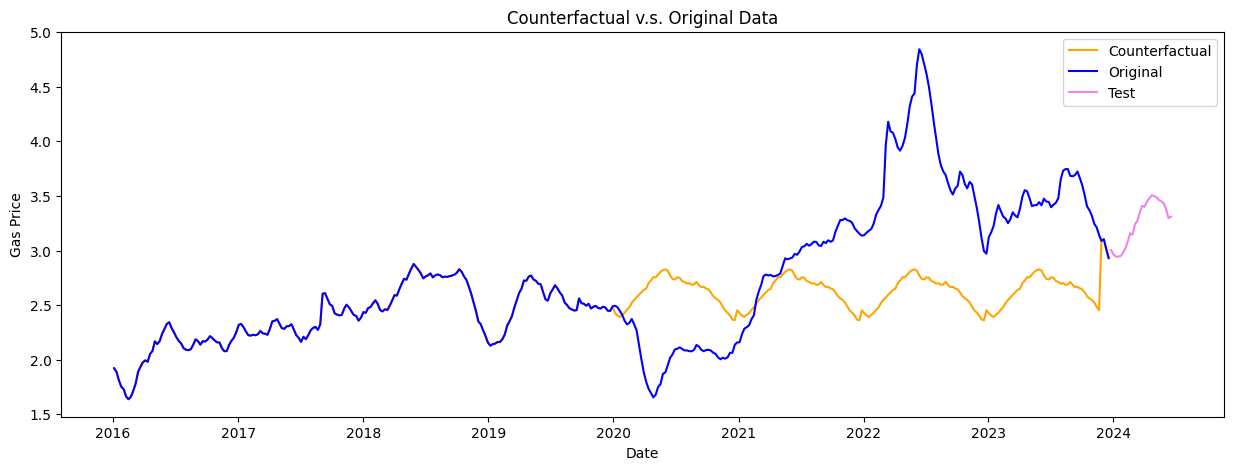

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
# Plot original data
ax.plot(train.loc ['2016':'2023']['price_per_gallon_forecast'], label='Counterfactual', color='orange')
ax.plot(train.loc['2016':'2023']['price_per_gallon'], label='Original', color='blue')
ax.plot(test['price_per_gallon'], label='Test', color='violet')
ax.set_xlabel('Date')
ax.set_ylabel('Gas Price')
ax.set_title('Counterfactual v.s. Original Data')
plt.legend(loc='best')
plt.show()

# Training

In [ ]:
## build docker image

In [14]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh train-latest train {config['ecr_repository']}

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                                         
[+] Building 0.2s (2/3)                                                         
 => [internal] load build definition from train.Dockerfile                 0.1s
 => => transferring dockerfile: 1.19kB                                     0.0s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load metadata for docker.io/library/python:3.10.12-slim-bu  0.0s
[+] Building 0.3s (3/3)                                                         
 => [internal] load build definition from train.Dockerfile                 0.1s
 => => transferring dockerfile: 1.1

In [16]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if 'imageTag' in ecr_meta_data_dict and ecr_meta_data_dict['imageTag'].startswith('train'):
        train_image_tag = ecr_meta_data_dict['imageTag']

train_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{train_image_tag}'